## Sequential Monte Carlo

Simulate the following system:

$$y_t \sim \text{Poisson}(\exp(x_{t}))$$
$$ x_{t} = 0.6 \cdot x_{t-1} + \varepsilon, \ \varepsilon \sim \mathcal{N}(0,1)$$

In [28]:
import numpy as np
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
%matplotlib inline

def bootstrap_filter(Y, N, T, x_0, alpha):
    '''
    Implement boostrap filter, as described in Doucet, de Freitas & Gordon, 2001.
    Returns resampled particles after N iterations, marginal likelihood p(y_{1:t})
    '''
        
    marginal_likelihood = 1.0
    particles = np.zeros((N, T+1))
    particles[:,0] = np.ones((N,))*x_0
    for t in range(1,T+1):
#         if t%100 == 0:
#             print(t)
        weights = np.zeros((N,))
        for i in range(N):
            prev_x = particles[i, t-1]
            rand_eps = norm.rvs()
            curr_x = alpha*prev_x + rand_eps
            particles[i, t] = curr_x

            # Evaluate importance weights
            weights[i] = poisson.pmf(Y[t-1], mu=np.exp(curr_x))
        
        marginal_likelihood = marginal_likelihood*np.mean(weights)
        normalized_weights = weights/np.sum(weights)
        # Now resample
        particles_before_resampling = particles[:, range(t+1)]    # Use range in order to create copy of array!
        for j in range(N):
            msk = np.random.choice(range(N), p=normalized_weights, replace=True)
            particles[j, 0:t+1] = particles_before_resampling[msk, 0:t+1]
        
    return particles, marginal_likelihood, normalized_weights

def MSE(sampled_particles, true_particles):
    return np.mean((sampled_particles - true_particles)**2, axis=0)

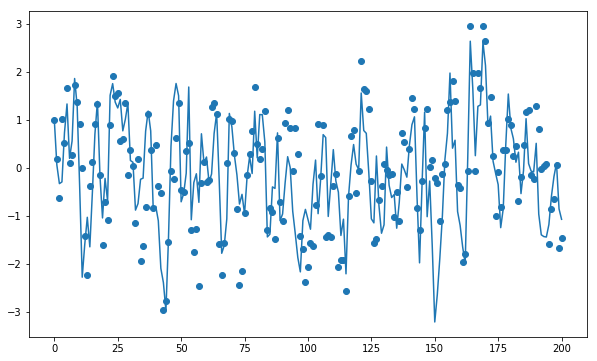

In [39]:
# Generate artificial data
T = 200
curr_x = 1
synt_y, synt_x = [], [curr_x]
for i in range(T):
    rand_eps = norm.rvs()
    curr_x = 0.6*curr_x + rand_eps
    synt_y.append(poisson.rvs(mu=np.exp(curr_x)))
    synt_x.append(curr_x)

synt_particles = bootstrap_filter(synt_y, 1000, 200, x_0=1, alpha=0.6)[0]
plt.figure(figsize=(10,6))
plt.scatter(range(T+1), synt_x)
plt.plot(range(T+1), np.mean(synt_particles, axis=0))

Text(0.5,1,'MSE for estimated $x_{t}$')

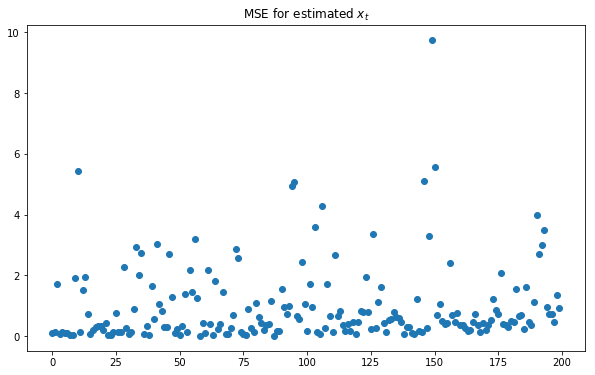

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(range(T), MSE(synt_particles, np.array(synt_x))[1:])
plt.title(r'MSE for estimated $x_{t}$')

In [106]:
MSE(synt_particles, np.array(synt_x))[5]

0.13413512440723357

In [108]:
second_col = synt_particles[:,5]
np.mean((second_col-synt_x[5])**2, axis=0)

0.1341351244072367

In [24]:
# Implement PMMH (Andrieu et al, 2011) to obtain PMCMC estimate of alpha
# Use Uniform(0,1) prior.
from scipy.stats import uniform
import warnings
warnings.simplefilter("error")

def PMMH(Y, N, T, x_0, scale_alpha, MC_iter):
    
    curr_alpha = uniform.rvs()
    curr_particles, curr_marg_likelihood, normalized_weights = bootstrap_filter(Y, N, T, x_0, curr_alpha)
    curr_particle = curr_particles[np.random.choice(range(N), p=normalized_weights)]  # Sample x_{1:t}
    samples_alpha = []
    accepted_alpha = 0.0
    
    for i in range(MC_iter):
        if i%100==0:
            print(i)
        cand_alpha = norm.rvs(scale=scale_alpha) + curr_alpha
        if 0<cand_alpha<1:
            cand_particles, cand_marg_likelihood, cand_normalized_weights = bootstrap_filter(Y, N, T, x_0, cand_alpha) 
            cand_particle = cand_particles[np.random.choice(range(N), p = cand_normalized_weights)]
            ratio = min(0, np.log(cand_marg_likelihood) + uniform.logpdf(cand_alpha) - 
                       np.log(curr_marg_likelihood) - uniform.logpdf(curr_alpha))
            U = uniform.rvs()
            if U <= np.exp(ratio):
                curr_alpha = cand_alpha
                curr_particle = cand_particle
                curr_marg_likelihood = cand_marg_likelihood
                accepted_alpha += 1
        samples_alpha.append(curr_alpha)
        
    plt.figure(figsize=(10,6))
    plt.plot(range(MC_iter), samples_alpha)
    plt.title('Samples of alpha, mean : {}, acceptance : {}'.format(np.mean(samples_alpha[int(MC_iter/3):]), accepted_alpha/MC_iter))
    return samples_alpha

0
100


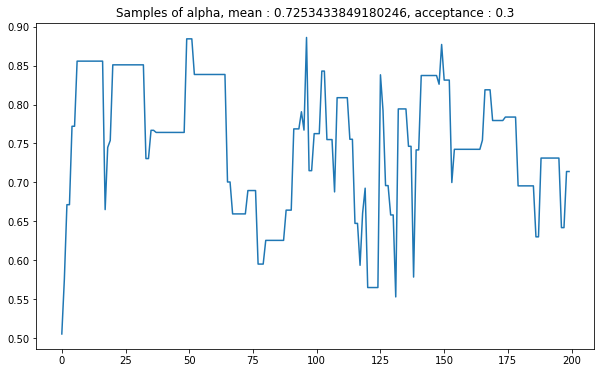

In [33]:
_ = PMMH(synt_y, 100, 100, 1, 0.1, 200)